In [1]:
#Installer la carte
!pip install folium --quiet

In [2]:
# telecharger les données depuis le git
!wget https://www.insee.fr/fr/statistiques/fichier/2540004/nat2019_csv.zip -O prenoms.csv.zip --quiet
!wget https://raw.githubusercontent.com/AlexChanson/Nom-de-rues-disparit-hommes-femmes/main/femmes.txt --quiet
!wget https://raw.githubusercontent.com/AlexChanson/Nom-de-rues-disparit-hommes-femmes/main/hommes.txt --quiet
!wget https://raw.githubusercontent.com/AlexChanson/Nom-de-rues-disparit-hommes-femmes/main/objets.txt --quiet
!wget https://raw.githubusercontent.com/AlexChanson/Nom-de-rues-disparit-hommes-femmes/main/rues_V5.csv --quiet
!wget https://raw.githubusercontent.com/AlexChanson/Nom-de-rues-disparit-hommes-femmes/main/troncons-de-voies-du-referentiel-voies-et-adresses-de-rennes-metropole.csv --quiet

In [3]:
import pandas as pd
import folium
import json
from IPython.display import display
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot

In [4]:
links = pd.read_csv("rues_V5.csv", encoding="windows-1251")
base = "http://www.wiki-rennes.fr"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


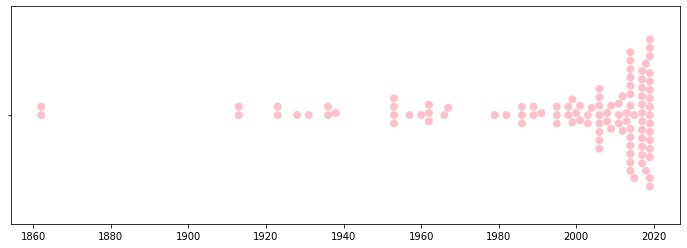

In [6]:
years = list(map(lambda s : datetime.strptime(s, '%Y-%m-%d').year, filter( lambda x : x != 'None', links["date"].to_list())))
fig, ax = pyplot.subplots(figsize=(12,4))
sns.swarmplot(years, color="pink", size = 8, ax=ax)

In [7]:
# Construction d'un dictionaire prénom -> genre à partir de données INSEE (~3min run time)
names = pd.read_csv("prenoms.csv.zip", sep=";")
names = names[names["preusuel"] != "_PRENOMS_RARES"]
counted = names.groupby(["sexe", "preusuel"]).sum()
counted = counted.reset_index()

names = set()
genre = dict()

for name in counted.preusuel:
  names.add(name)

for name in names:
  h = counted[(counted.preusuel == name) & (counted.sexe == 1)]["nombre"]
  f = counted[(counted.preusuel == name) & (counted.sexe == 2)]["nombre"]
  if len(h) == 0:
    h = 0
  else:
    h = int(h)
  if len(f) == 0:
    f = 0
  else:
    f = int(f)
  genre[name.lower()] = "h" if h > f else "f"

In [9]:
objects = {"square de sofia", "rue de la nida", "rue de la néva", "allée de la maritza", "rond-point colonel diègue santa"}
femmes = set()
hommes = set()

with open("femmes.txt") as f:
  for line in f:
    femmes.add(line.strip().lower())
with open("hommes.txt") as f:
  for line in f:
    hommes.add(line.strip().lower())
with open("objets.txt") as f:
  for line in f:
    objects.add(line.strip().lower())

def getColor(name):
  # filtre exact basé sur une liste annoté main
  if name in objects:
    return "grey"
  if name in femmes:
    return '#f616e9'
  if name in hommes:
    return "cyan"

  # Filtre basé sur les données de prénoms INSEE si inconu  
  stopwords = ["le", "du", "de", "rue", "la", 'chemin', "liberté", "paris", "visitation", "castille", "bonne", "mai", "salle"]
  for token in name.split(' '):
    token = token.lower()
    if token in stopwords:
      continue
    if token in genre:
      if genre[token] == "h":
        return 'cyan'
      else:
        return '#f616e9'
  return 'grey'

In [20]:
m = folium.Map(
    width='100%', 
    height='100%',
    location=[48.111080611013335, -1.6779849864685281],
    zoom_start=12,
    tiles='Stamen Terrain'
)

In [21]:
data = pd.read_csv("troncons-de-voies-du-referentiel-voies-et-adresses-de-rennes-metropole.csv", sep=";")
count = set()

for ind in data.index:
  shape = data['Geo Shape'][ind]
  name_case = str(data['denomination'][ind])
  name = name_case.lower()

  lien = links[links.nom_rue == name_case]["lien_page"]
  if len(lien) > 0:
    popup = "<a href=" + base + lien.iloc[0] + ">" + name_case + "</a>"
  else:
    popup = name_case

  color = getColor(name)

  #filtre (skip if match)
  if False:
    continue
  else:
    count.add(name)

  # decodage du json et mise au bon format (inversion lat/long)
  line = json.loads(shape)["coordinates"][0]
  line = list(map(lambda p : (p[1], p[0]), line))
  folium.PolyLine(line, color=color, popup=popup).add_to(m)

print(len(count))

1961


In [22]:
m.save("map_all.html")

In [19]:
display(m)